# ONNX graph, single or double floats

The notebook shows discrepencies obtained by using double floats instead of single float in two cases. The second one involves [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Simple case of a linear regression

A linear regression is simply a matrix multiplication followed by an addition: $Y=AX+B$. Let's train one with [scikit-learn](https://scikit-learn.org/stable/).

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [3]:
clr.score(X_test, y_test)

0.7836975180890742

In [4]:
clr.coef_

array([-1.02626125e-01,  5.37157286e-02,  4.85401940e-04,  2.29933224e+00,
       -1.55768235e+01,  2.95197696e+00,  1.27833099e-02, -1.50176256e+00,
        3.86793001e-01, -1.46468258e-02, -9.10378501e-01,  9.96266806e-03,
       -6.34832141e-01])

In [5]:
clr.intercept_

40.84518080004733

Let's predict with *scikit-learn* and *python*.

In [6]:
ypred = clr.predict(X_test)
ypred[:5]

array([34.02095272,  8.03158922, 22.99227105, 21.87550536,  9.38806914])

In [7]:
py_pred = X_test @ clr.coef_ + clr.intercept_
py_pred[:5]

array([34.02095272,  8.03158922, 22.99227105, 21.87550536,  9.38806914])

In [8]:
clr.coef_.dtype, clr.intercept_.dtype

(dtype('float64'), dtype('float64'))

## With ONNX

With *ONNX*, we would write this operation as follows... We still need to convert everything into single floats = float32.

In [9]:
%load_ext mlprodict

In [10]:
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxAdd
import numpy

onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float32)),
                   numpy.array([clr.intercept_]),
                   output_names=['Y'])
onnx_model32 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float32)},
                              dtype=numpy.float32)

# add -l 1 if nothing shows up
%onnxview onnx_model32

The next line uses a python runtime to compute the prediction.

In [11]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(onnx_model32)
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([34.020954 ,  8.0315895, 22.99227  , 21.875505 ,  9.388069 ],
      dtype=float32)

And here is the same with [onnxruntime](https://github.com/microsoft/onnxruntime)...

In [12]:
oinf = OnnxInference(onnx_model32, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([34.020954 ,  8.0315895, 22.992271 , 21.875505 ,  9.388065 ],
      dtype=float32)

## With double instead of single float

[ONNX](https://onnx.ai/) was originally designed for deep learning which usually uses floats but it does not mean cannot be used. Every number is converted into double floats.

In [13]:
onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float64)),
                   numpy.array([clr.intercept_]),
                   output_names=['Y'])
onnx_model64 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float64)},
                              dtype=numpy.float64)

And now the *python* runtime...

In [14]:
oinf = OnnxInference(onnx_model64)
ort_pred = oinf.run({'X': X_test})['Y']
ort_pred[:5]

array([34.02095272,  8.03158922, 22.99227105, 21.87550536,  9.38806914])

And the *onnxruntime* version of it, not fully supportive of double yet...

In [15]:
try:
    oinf = OnnxInference(onnx_model64, runtime="onnxruntime1")
    ort_pred = oinf.run({'X': X_test.astype(numpy.float64)})['Y']
    ort_pred[:5]
except RuntimeError as e:
    print(e)

[ONNXRuntimeError] : 9 : NOT_IMPLEMENTED : Could not find an implementation for the node Ad_Add:Add(7)


## And now the GaussianProcessRegressor

This shows a case

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
gau = GaussianProcessRegressor(alpha=10, kernel=DotProduct())
gau.fit(X_train, y_train)

GaussianProcessRegressor(alpha=10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [17]:
from skl2onnx import to_onnx
onnxgau32 = to_onnx(gau, X_train.astype(numpy.float32), dtype=numpy.float32)
oinf32 = OnnxInference(onnxgau32, runtime="python")
ort_pred32 = oinf32.run({'X': X_test.astype(numpy.float32)})['GPmean']
numpy.squeeze(ort_pred32)[:25]

array([33.125,  6.625, 23.5  , 22.625, 10.25 , 19.75 , 13.75 , 17.25 ,
       31.   , 16.   , 25.625, 18.375, 33.625, 42.625, 35.75 , 21.   ,
       19.   , 22.625, 24.75 , 15.   , 31.   ,  7.625, 13.5  ,  4.   ,
       25.25 ], dtype=float32)

In [18]:
onnxgau64 = to_onnx(gau, X_train.astype(numpy.float64), dtype=numpy.float64)
oinf64 = OnnxInference(onnxgau64, runtime="python")
ort_pred64 = oinf64.run({'X': X_test.astype(numpy.float64)})['GPmean']
numpy.squeeze(ort_pred64)[:25]

array([33.16219135,  6.80583637, 23.8054958 , 23.02496476, 10.0123476 ,
       19.74633171, 14.22049743, 17.50913404, 31.23975419, 15.5676655 ,
       25.91874293, 19.14989035, 33.89588065, 43.37730604, 35.97438905,
       21.04844868, 19.1410149 , 22.71168399, 25.04743772, 14.6211457 ,
       31.13142217,  7.47344522, 14.59039259,  4.16909152, 24.71047251])

The differences between the predictions for single floats and double floats...

In [19]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - ort_pred64)))[-5:]

array([0.73869556, 0.7735361 , 0.8158365 , 0.90728579, 1.63133946])

Who's right or wrong... The differences between the predictions with the original model...

In [20]:
pred = gau.predict(X_test.astype(numpy.float64))

In [21]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - pred)))[-5:]

array([0.73869556, 0.7735361 , 0.8158365 , 0.90728579, 1.63133946])

In [22]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred64 - pred)))[-5:]

array([0., 0., 0., 0., 0.])

Double predictions clearly wins.

In [23]:
# add -l 1 if nothing shows up
%onnxview onnxgau64

## Saves...

Let's keep track of it.

In [24]:
with open("gpr_dot_product_boston_32.onnx", "wb") as f:
    f.write(onnxgau32.SerializePartialToString())
from IPython.display import FileLink
FileLink('gpr_dot_product_boston_32.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_32.onnx

In [25]:
with open("gpr_dot_product_boston_64.onnx", "wb") as f:
    f.write(onnxgau64.SerializePartialToString())
FileLink('gpr_dot_product_boston_64.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_64.onnx

## Side by side

We may wonder where the discrepencies start. But for that, we need to do a side by side.

In [26]:
from mlprodict.onnxrt.side_by_side import side_by_side_by_values
sbs = side_by_side_by_values([(oinf32, {'X': X_test.astype(numpy.float32)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])

from pandas import DataFrame
df = DataFrame(sbs)
# dfd = df.drop(['value[0]', 'value[1]', 'value[2]'], axis=1).copy()
df

,cmp,metric,name,shape[0],shape[1],step,v[0],v[1],value[0],value[1]
0,OK,nb_results,NaN,NaN,NaN,-1,10,1.000000e+01,NaN,NaN
1,OK,abs-diff,X,"(127, 13)","(127, 13)",0,0,5.553783e-08,"[[0.03768, 80.0, 1.52, 0.0, 0.404, 7.274, 38.3...","[[0.03768, 80.0, 1.52, 0.0, 0.404, 7.274, 38.3..."
2,OK,abs-diff,kgpd_MatMulcst,"(13, 379)","(13, 379)",1,0,5.647917e-08,"[[0.1712, 0.07896, 0.08308, 0.04011, 0.21977, ...","[[0.1712, 0.07896, 0.08308, 0.04011, 0.21977, ..."
3,OK,abs-diff,kgpd_Addcst,"(1,)","(1,)",2,0,4.773335e-08,[1073.5477],[1073.5477807362217]
4,OK,abs-diff,gpr_MatMulcst,"(379,)","(379,)",3,0,5.481368e-08,"[0.2759209, -0.01826272, 0.30508244, -0.164773...","[0.2759209068378013, -0.018262720128066828, 0...."
5,OK,abs-diff,gpr_Addcst,"(1, 1)","(1, 1)",4,0,0.000000e+00,[[0.0]],[[0.0]]
6,OK,abs-diff,kgpd_O02,"(127, 379)","(127, 379)",5,0,1.729052e-07,"[[285506.28, 286446.3, 220675.92, 271909.88, 2...","[[285506.252193816, 286446.3127387128, 220675...."
7,OK,abs-diff,kgpd_O01,"(127, 379)","(127, 379)",6,0,2.197289e-07,"[[286579.84, 287519.88, 221749.47, 272983.44, ...","[[286579.79997455224, 287519.86051944905, 2217..."
8,OK,abs-diff,kgpd_O0,"(127, 379)","(127, 379)",7,0,2.197289e-07,"[[286579.84, 287519.88, 221749.47, 272983.44, ...","[[286579.79997455224, 287519.86051944905, 2217..."
9,e<0.1,abs-diff,gpr_O0,"(127,)","(127,)",8,0,6.591271e-02,"[33.125, 6.625, 23.5, 22.625, 10.25, 19.75, 13...","[33.162191349547356, 6.8058363744057715, 23.80..."


The differences really starts for output ``'O0'`` after the matrix multiplication. This matrix melts different number with very different order of magnitudes and that alone explains the discrepencies with doubles and floats on that particular model.

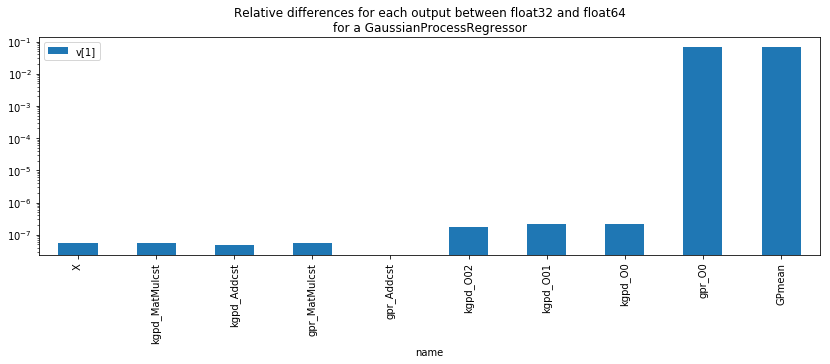

In [27]:
%matplotlib inline
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float32 and float64\nfor a GaussianProcessRegressor");

Before going further, let's check how sensitive the trained model is about converting double into floats.

In [28]:
pg1 = gau.predict(X_test)
pg2 = gau.predict(X_test.astype(numpy.float32).astype(numpy.float64))
numpy.sort(numpy.sort(numpy.squeeze(pg1 - pg2)))[-5:]

array([1.22073106e-06, 1.26985833e-06, 1.29081309e-06, 1.53481960e-06,
       1.54972076e-06])

Having float or double inputs should not matter. We confirm that with the model converted into ONNX.

In [29]:
p1 = oinf64.run({'X': X_test})['GPmean']
p2 = oinf64.run({'X': X_test.astype(numpy.float32).astype(numpy.float64)})['GPmean']
numpy.sort(numpy.sort(numpy.squeeze(p1 - p2)))[-5:]

array([1.22073106e-06, 1.26985833e-06, 1.29081309e-06, 1.53481960e-06,
       1.54972076e-06])

Last verification.

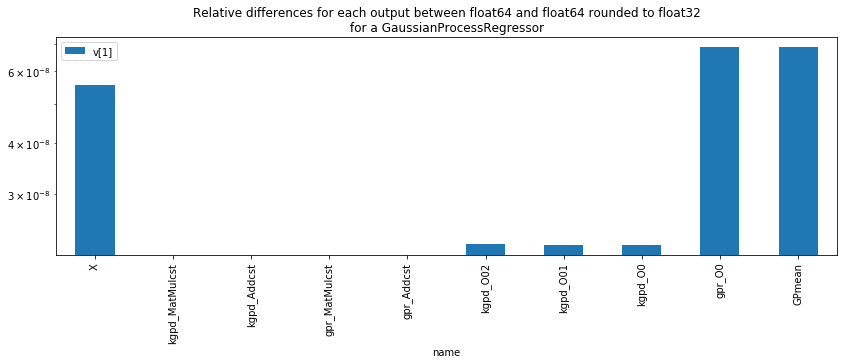

In [30]:
sbs = side_by_side_by_values([(oinf64, {'X': X_test.astype(numpy.float32).astype(numpy.float64)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])
df = DataFrame(sbs)
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float64 and float64 rounded to float32"
             "\nfor a GaussianProcessRegressor");

## Partial use of float64

In [31]:
onnxgau48 = to_onnx(gau, X_train.astype(numpy.float32), dtype=numpy.float32,
                    options={GaussianProcessRegressor: {'float64': True}})
%onnxview onnxgau48

In [32]:
oinf48 = OnnxInference(onnxgau48, runtime="python")
ort_pred48 = oinf48.run({'X': X_test.astype(numpy.float32)})['GPmean']
numpy.sort(numpy.sort(numpy.squeeze(ort_pred48 - ort_pred64)))[-5:]

array([0.16995945, 0.17210525, 0.20095541, 0.20111441, 0.24590116])

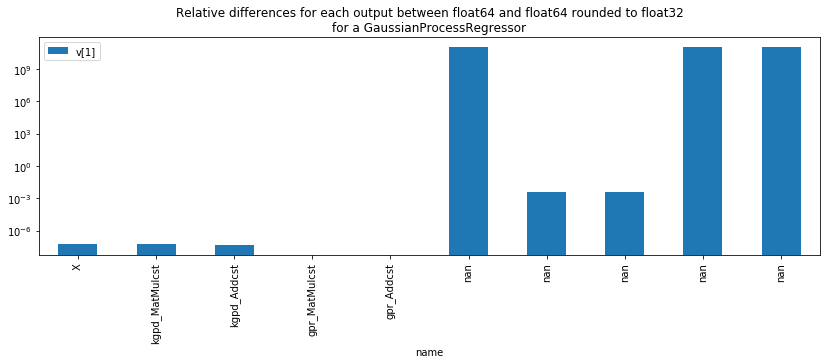

In [33]:
sbs = side_by_side_by_values([(oinf48, {'X': X_test.astype(numpy.float32)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])
df = DataFrame(sbs)
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float64 and float64 rounded to float32"
             "\nfor a GaussianProcessRegressor");

In [34]:
df

,cmp,metric,name,names,shape[0],shape[1],step,v[0],v[1],value[0],value[1]
0,!=,nb_results,NaN,NaN,NaN,NaN,-1,14,1.000000e+01,NaN,NaN
1,OK,abs-diff,X,NaN,"(127, 13)","(127, 13)",0,0,5.553783e-08,"[[0.03768, 80.0, 1.52, 0.0, 0.404, 7.274, 38.3...","[[0.03768, 80.0, 1.52, 0.0, 0.404, 7.274, 38.3..."
2,OK,abs-diff,kgpd_MatMulcst,NaN,"(13, 379)","(13, 379)",1,0,5.647917e-08,"[[0.1712000072002411, 0.07896000146865845, 0.0...","[[0.1712, 0.07896, 0.08308, 0.04011, 0.21977, ..."
3,OK,abs-diff,kgpd_Addcst,NaN,"(1,)","(1,)",2,0,4.773335e-08,[1073.5477],[1073.5477807362217]
4,OK,abs-diff,gpr_MatMulcst,NaN,"(379,)","(379,)",3,0,0.000000e+00,"[0.2759209068378013, -0.018262720128066828, 0....","[0.2759209068378013, -0.018262720128066828, 0...."
5,OK,abs-diff,gpr_Addcst,NaN,"(1, 1)","(1, 1)",4,0,0.000000e+00,[[0.0]],[[0.0]]
6,ERROR->=100000000000.0,abs-diff,NaN,kgpd_O02 -> kgpd_O04,"(127, 13)","(127, 379)",5,0,1.000000e+11,"[[0.0376800000667572, 80.0, 1.5199999809265137...","[[285506.252193816, 286446.3127387128, 220675...."
7,e<0.01,abs-diff,NaN,kgpd_O01 -> kgpd_O03,"(127, 379)","(127, 379)",6,0,3.969042e-03,"[[285506.26227946434, 286446.3228386466, 22067...","[[286579.79997455224, 287519.86051944905, 2217..."
8,e<0.01,abs-diff,NaN,kgpd_O0 -> kgpd_O02,"(127, 379)","(127, 379)",7,0,3.969088e-03,"[[285506.25, 286446.3, 220675.9, 271909.88, 23...","[[286579.79997455224, 287519.86051944905, 2217..."
9,ERROR->=100000000000.0,abs-diff,NaN,gpr_O0 -> kgpd_O01,"(127, 379)","(127,)",8,0,1.000000e+11,"[[286579.8, 287519.88, 221749.45, 272983.44, 2...","[33.162191349547356, 6.8058363744057715, 23.80..."
